# bgfs.ipynb

Fit various functions to COVID-19 time series for U.S. counties using the Broyden–Fletcher–Goldfarb–Shanno solver from `sklearn.optimize`.

Inputs:
* `data/us_counties_clean.csv`: The contents of `data/us_counties.csv` after data cleaning by `clean.ipynb`
* `data/us_counties_clean_meta.json`: Column type metadata for reading `data/us_counties_clean.csv` with `pd.read_csv()`

Outputs:
* `data/us_counties_curves.csv`: The curves that this notebook generated
* `data/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `data/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`


In [1]:
# Initialization boilerplate
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# What precision of floating-point to use.
# Consider 32-bit if using GPU-accelerated solvers. Otherwise, 64-bit
# floating point is better because it reduces the chance of divergence.
fp_type = np.float64



In [2]:
# Read in the CSV file and apply the saved type information
csv_file = "data/us_counties_clean.csv"
meta_file = "data/us_counties_clean_meta.json"

# Read column type metadata
with open(meta_file) as f:
    cases_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
cases_meta["Date"] = "object"

cases_vertical = (
    pd
    .read_csv(csv_file, dtype=cases_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-04-21  Wyoming   Weston        6927          0       0          0   
      2020-04-22  Wyoming   Weston        6927          0       0          0   
      2020-04-23  Wyoming   Weston        6927          0       0          0   
      2020-04-24  Wyoming   Weston        6927          0       0          0   
      2020-04-25  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22              False           False              False  
      2020-01-23              False           False              False  
      2020-01-24              False           False              False  
      2020-01-25              False           False              False  
      2020-01-26              False           False              False  
...                             ...             ...                ...  
56045 2020-04-21              False           False              False  
      2020-04-22              False           False              False  
      2020-04-23              False           False              False  
      2020-04-24              False           False              False  
      2020-04-25              False           False              False  

[298490 rows x 9 columns]

In [3]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
for col in ["Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"]:
    cases_vertical[col] = cases_vertical[col].astype(np.int8)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-04-21  Wyoming   Weston        6927          0       0          0   
      2020-04-22  Wyoming   Weston        6927          0       0          0   
      2020-04-23  Wyoming   Weston        6927          0       0          0   
      2020-04-24  Wyoming   Weston        6927          0       0          0   
      2020-04-25  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22                  0               0                  0  
      2020-01-23                  0               0                  0  
      2020-01-24                  0               0                  0  
      2020-01-25                  0               0                  0  
      2020-01-26                  0               0                  0  
...                             ...             ...                ...  
56045 2020-04-21                  0               0                  0  
      2020-04-22                  0               0                  0  
      2020-04-23                  0               0                  0  
      2020-04-24                  0               0                  0  
      2020-04-25                  0               0                  0  

[298490 rows x 9 columns]

In [4]:
# Use Text Extensions for Pandas to collapse each time series or mask down to a single cell
cases, dates = util.collapse_time_series(cases_vertical, [
    "Confirmed", "Deaths", "Recovered", 
    "Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"])
cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
# To simplify the code that follows, we only fit curves to one of
# the time series for each county. 
# Change the following constant to use a different time series:
ts_col_name = "Confirmed"

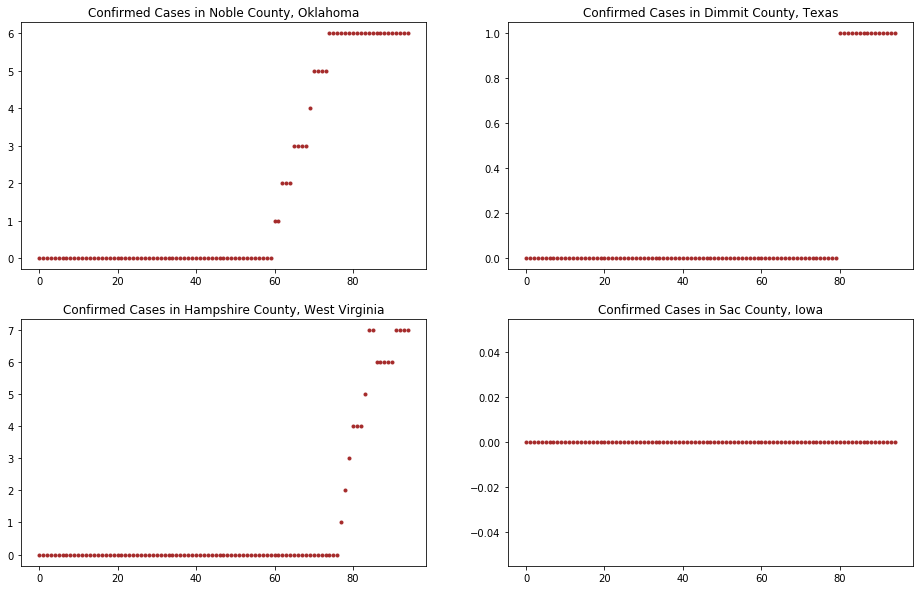

In [6]:
# Because these time series are integer-valued, there can be
# problems with aliasing. 
# Here are some examples of what aliasing looks like:
# (graph_examples() function defined in util.py)
util.graph_examples(cases, ts_col_name, {}, 
                    mask=(np.max(cases[ts_col_name].values, axis=1) < 10))

In [7]:
# To avoid problems due to aliasing, we will restrict the analysis
# in the rest of this notebook to time series whose maximum values
# go above a threshold:
alias_threshold = 100

# We also cut off the sections at the beginning of the time 
# series where every time series' value is below this threshold.

# Find what point in the time series at least one county went above
# the threshold.
first_time_above_min = np.argmax(np.max(cases[ts_col_name].values, axis=0) >= alias_threshold)
print(f"Dropping the first {first_time_above_min} elements of each time series.")

# Find which counties have at least one time series value above the 
# threshold.
counties_mask = np.max(cases[ts_col_name].values, axis=1) >= alias_threshold

# Filter rows
filtered = cases[counties_mask].copy(deep=True)

# Truncate time series to just the times when at least one county
# was above our threshold.
filtered[ts_col_name] = filtered[ts_col_name].values[:,first_time_above_min:]

# Also filter the outlier masks
outlier_col_name = ts_col_name + "_Outlier"
filtered[outlier_col_name] = filtered[outlier_col_name].values[:,first_time_above_min:]

filtered_dates = dates[first_time_above_min:]

# Drop time series columns other than the one we analyze
series_to_keep = [ts_col_name, outlier_col_name]
metadata_cols = []
to_drop = []
for colname in filtered.columns:
    if not isinstance(filtered[colname].dtype, tp.TensorType):
        metadata_cols.append(colname)
    elif colname not in series_to_keep:
        to_drop.append(colname)
        
filtered = filtered.drop(columns=to_drop)

filtered

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Confirmed_Outlier
FIPS,,,,,
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1055,Alabama,Etowah,102268,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1073,Alabama,Jefferson,658573,[ 0 0 0 1 1 5 17 21 25 34 50 6...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1081,Alabama,Lee,164542,[ 0 0 0 0 0 0 1 3 8 10 11 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...
55101,Wisconsin,Racine,196311,[ 0 0 0 1 1 1 1 1 1 3 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
55105,Wisconsin,Rock,163354,[ 0 0 0 0 0 0 0 0 0 0 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
55127,Wisconsin,Walworth,103868,[ 0 0 0 0 0 0 0 0 1 2 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [8]:
# Warm-up: Fit a straight line.
# We use sklearn's implementation of BGFS as the optimizer.

# What precision of floating-point to use
# On a laptop, there's not much reason to use 32-bit.
fp_type = np.float64
series_values = filtered[ts_col_name].values.astype(fp_type)
series_len = series_values.shape[1]
x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)

def linear_curve(m, b):
    return m * x + b

def linear_objective(var_values, y):
    m, b = var_values
    return np.sum((y - (linear_curve(m, b))) ** 2)

linear_initial_guess = (0.1, 1.0)
linear_bounds = ((0.0, 1000.0), (float(-series_len), float(series_len)))

linear = filtered[metadata_cols].copy()
linear["Result_Object"] = [
    scipy.optimize.minimize(
        linear_objective, linear_initial_guess,
        args=(ts), bounds=linear_bounds)
    for ts in series_values
]
linear["Slope"] = linear["Result_Object"].apply(lambda r: r.x[0])
linear["Intercept"] = linear["Result_Object"].apply(lambda r: r.x[1])

# Generate all the linear curves
M = linear["Slope"].values.reshape([-1, 1])
X = x.reshape([1, -1])
B = linear["Intercept"].values.reshape([-1, 1])
linear["Curve"] = tp.TensorArray(M * X + B)

# Compute coefficient of determination
linear["R^2"] = [
    metrics.r2_score(
        filtered.loc[fips][ts_col_name], linear.loc[fips]["Curve"]) 
        for fips in filtered.index]

linear

,State,County,Population,Result_Object,Slope,Intercept,Curve,R^2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 13865.547525439672, 'jac': [0.00218278...",3.325277,-32.140953,[-32.14095299 -28.81567559 -25.49039819 -22.165...,0.873363
1017,Alabama,Chambers,33254,"{'fun': 54834.42529318731, 'jac': [-0.00072759...",6.667423,-47.000000,[-47. -40.33257736 -33.66515471 -26.997...,0.893046
1055,Alabama,Etowah,102268,"{'fun': 10853.057816836277, 'jac': [0.00090949...",2.953515,-29.441488,[-2.94414882e+01 -2.64879730e+01 -2.35344578e+0...,0.874228
1073,Alabama,Jefferson,658573,"{'fun': 128513.0095789444, 'jac': [0.005820766...",17.753574,-47.000000,[-47. -29.24642647 -11.49285295 6.260...,0.963116
1081,Alabama,Lee,164542,"{'fun': 57529.12190027155, 'jac': [0.0, 564.64...",8.065978,-47.000000,[-47. -38.93402167 -30.86804333 -22.802...,0.920455
...,...,...,...,...,...,...,...,...
55101,Wisconsin,Racine,196311,"{'fun': 35249.95461191848, 'jac': [0.0, 74.515...",5.043717,-47.000000,[-47. -41.95628301 -36.91256601 -31.868...,0.866408
55105,Wisconsin,Rock,163354,"{'fun': 9324.586378353406, 'jac': [0.002364686...",2.453168,-22.763297,[-22.76329742 -20.31012904 -17.85696067 -15.403...,0.848056
55127,Wisconsin,Walworth,103868,"{'fun': 13474.471322850286, 'jac': [0.0, 0.000...",2.378584,-24.856374,[-24.85637357 -22.47778924 -20.0992049 -17.720...,0.784070


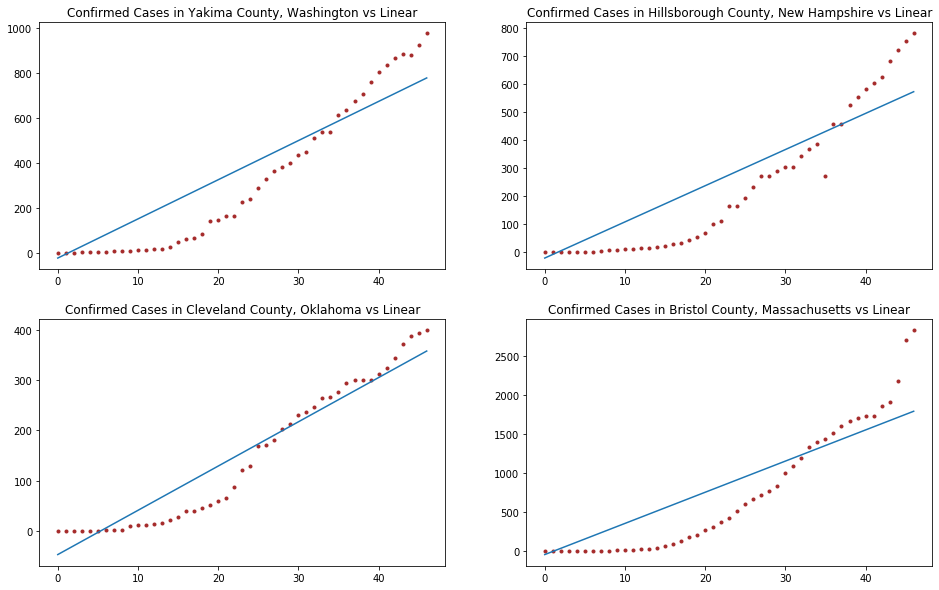

In [9]:
# Plot the lines we just fit, using the graph_examples() function in util.py.
util.graph_examples(filtered, ts_col_name, {"Linear": linear})

In [10]:
# Now let's fit some more appropriate curves to this data.
# First, break out the repetitive parts of the curve-fitting process into
# a Python function.
def curve_fit_df(df: pd.DataFrame, ts_col_name: str,
                 curve_fn,
                 param_names: Tuple,
                 initial_guess: Tuple,
                 bounds: Tuple,     
                 regularize_fn = None):
    """
    Fit a curve to a column full of time series.
    
    :param df: DataFrame containing one time series per cell
    :param ts_col_name: Column containing the time series to analyze
    :param curve_fn: Function that, if called with a vector of X values
     and a tuple of parameters, will compute the value of the curve 
     being fit.
     If parameters are vectors, this function must compute multiple
     curves, one for each element of the vectors.
    
    :param param_names: Names of the parameters of `curve_fn`.
    :param initial_guess: Initial values for the paramters to start
     off the solver.
    :param bounds: Lower and upper bounds for the parameters.
    :param regularize_fn: Optional function that returns a 
     regularization penalty, given a set of parameter values.
    
    :returns: A dataframe with one row per row of `df`, containing
     information about the 
    """
    series_values = df[ts_col_name].values.astype(fp_type)
    series_len = series_values.shape[1]
    x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)
    
    def return_zero(var_values):
        return 0.0
    
    if regularize_fn is None:
        regularize_fn = return_zero
    
    def objective(var_values, y):
        squared_diffs = np.sum((y - (curve_fn(x, var_values))) ** 2)
        return squared_diffs + regularize_fn(var_values)
    
    result = pd.DataFrame(index=df.index)
    result[metadata_cols] = df[metadata_cols]
    result["Result_Object"] = [
        scipy.optimize.minimize(
            objective, initial_guess,
            args=(ts), bounds=bounds)
        for ts in series_values
    ]
    
    # Add a column for each parameter
    for i in range(len(param_names)):
        name = param_names[i]
        result[name] = result["Result_Object"].apply(lambda r: r.x[i])

    # Generate all the curves
    param_vectors = [
        result[name].values.reshape([-1, 1])
        for name in param_names
    ]
    result["Curve"] = tp.TensorArray(curve_fn(x, param_vectors))

    # Compute coefficient of determination
    result["R^2"] = [
        metrics.r2_score(
            df.loc[fips][ts_col_name], result.loc[fips]["Curve"]) 
            for fips in df.index]

    return result

In [11]:
# Define curve-fitting routines using the function from the previous
# cell.

def fit_exponential(ts_col_name: str):
    """
    Fit an exponential curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        rate, offset = var_values
        # Y = e^(rate)(X - offset)
        return np.exp(rate * (x - offset))
    
    param_names = ("Rate", "Offset")
    initial_guess = (0.1, 1.0)
    bounds = ((0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic(ts_col_name: str):
    """
    Fit a logistic curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        max_, rate, offset = var_values
        # Y = max / (1 + e^(-rate *(X - offset))
        return max_ / (1.0 + np.exp(-rate * (x - offset)))
    
    param_names = ("Max", "Rate", "Offset")
    initial_guess = (1000.0, 0.1, 1.0)
    bounds = ((0.0, 1e6), (0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic2(ts_col_name: str):
    """
    Fit a mixture of two logistic curve sto each time series in the 
    specified column of the `cases` dataframe.
    """
    # Distance from X=0 at which the logistic function is close enough to 0 or 1
    # that we can consider it to have "triggered"
    logistic2_limit = np.array(6., dtype=fp_type)
    
    def curve_fn(x, var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        
        # logistic curve is Y = max / (1 + e^(-rate *(X - offset))
        logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
        logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))

        # What fraction of the output comes from logistic2?
        def sigmoid(x_):
            return 1. / (1. + np.exp(-x_))
        
        mix_input = (x - switch_begin - logistic2_limit) / np.maximum(1.0, (switch_end - switch_begin))
        return logistic1 * (1.0 - sigmoid(mix_input)) + logistic2 * sigmoid(mix_input)
    
    def regularize_fn(var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        reg_coeff = 1e7
        linear_terms = [
            max(0.0, switch_begin - switch_end - 1.0)  # switch_end >= switch_begin + 1
        ]
        return reg_coeff * sum([t for t in linear_terms])
    
    param_names = (
        "Max1", "Rate1", "Offset1",
        "Max2", "Rate2", "Offset2",
        "Switch_Begin", "Switch_End")
    initial_guess = (
        1000.0, 0.1, 1.0,  # First logistic function
        1000.0, 0.1, 1.0,  # Second logistic function
        10.0, 20.0  # Switchover
    )
    series_len = len(filtered_dates)
    bounds = (
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # First logistic function
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # Second logistic function
        (0.0, float(series_len)), (0.0, float(series_len))  # Switchover
    )
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds,
                        regularize_fn=regularize_fn)


In [12]:
# Now we can fit those curves.
# First, the exponential curves.
exp_df = fit_exponential(ts_col_name)
exp_df

,State,County,Population,Result_Object,Rate,Offset,Curve,R^2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 12073.153247162143, 'jac': [0.00072759...",0.114329,0.0,[ 1. 1.12112042 1.25691099 1.409...,0.889733
1017,Alabama,Chambers,33254,"{'fun': 173494.9334709798, 'jac': [0.008731149...",0.131228,0.0,[ 1. 1.14022777 1.30011936 1.482...,0.661600
1055,Alabama,Etowah,102268,"{'fun': 12897.714216477843, 'jac': [0.00236468...",0.110894,0.0,[ 1. 1.11727607 1.24830582 1.394...,0.850534
1073,Alabama,Jefferson,658573,"{'fun': 2948566.6113237045, 'jac': [2.88709998...",0.154413,0.0,[1.00000000e+00 1.16697306e+00 1.36182612e+00 1...,0.153753
1081,Alabama,Lee,164542,"{'fun': 301862.99504820886, 'jac': [-1.6239937...",0.136078,0.0,[ 1. 1.14577107 1.31279135 1.504...,0.582615
...,...,...,...,...,...,...,...,...
55101,Wisconsin,Racine,196311,"{'fun': 34323.40115579235, 'jac': [1.606531441...",0.124473,0.0,[ 1. 1.13255135 1.28267257 1.452...,0.869919
55105,Wisconsin,Rock,163354,"{'fun': 4843.976430737943, 'jac': [0.0, 388.30...",0.107981,0.0,[ 1. 1.11402615 1.24105425 1.382...,0.921067
55127,Wisconsin,Walworth,103868,"{'fun': 1966.3987317076812, 'jac': [0.00059117...",0.107348,0.0,[ 1. 1.11332211 1.23948611 1.379...,0.968488


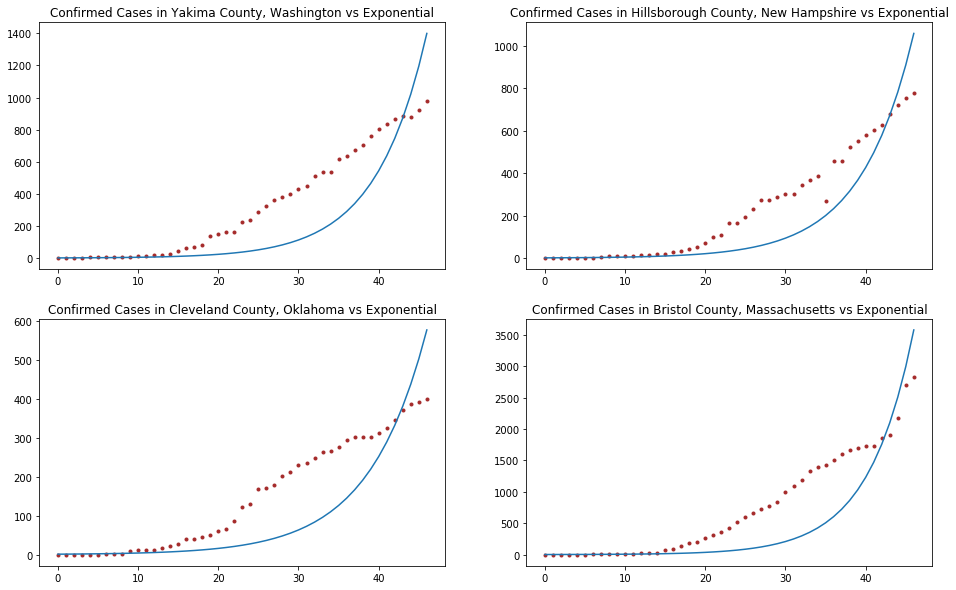

In [13]:
util.graph_examples(filtered, ts_col_name, {"Exponential": exp_df})

In [14]:
# Then fit the logistic function
log_df = fit_logistic(ts_col_name)
log_df

,State,County,Population,Result_Object,Max,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 327.1319907889779, 'jac': [-2.84217094...",177.284243,0.152563,35.760551,[ 0.75409466 0.87776585 1.02160168 1.188...,0.997012
1017,Alabama,Chambers,33254,"{'fun': 2177.521248150691, 'jac': [4.547473508...",284.217840,0.211732,29.769072,[ 0.5193638 0.64156192 0.79243101 0.978...,0.995753
1055,Alabama,Etowah,102268,"{'fun': 879.0311047264508, 'jac': [6.821210263...",123.709407,0.198530,31.860802,[ 0.22109095 0.26953866 0.32857448 0.400...,0.989813
1073,Alabama,Jefferson,658573,"{'fun': 20951.052533768667, 'jac': [-0.0014551...",782.991911,0.152555,25.726480,[ 15.16306677 17.60584955 20.43169486 23.697...,0.993987
1081,Alabama,Lee,164542,"{'fun': 3973.852587581014, 'jac': [4.547473508...",379.217731,0.161801,30.451090,[ 2.72881123 3.20401358 3.7611422 4.414...,0.994505
...,...,...,...,...,...,...,...,...,...
55101,Wisconsin,Racine,196311,"{'fun': 1980.8722559855912, 'jac': [-2.2737367...",296.500229,0.142735,37.107462,[ 1.47777235 1.70319504 1.96277544 2.261...,0.992493
55105,Wisconsin,Rock,163354,"{'fun': 2449.37170870858, 'jac': [9.0949470177...",254.178909,0.103884,47.000000,[ 1.91157133 2.11909047 2.348928 2.603...,0.960088
55127,Wisconsin,Walworth,103868,"{'fun': 894.0937329094957, 'jac': [-1.13686837...",187.483419,0.146212,41.784218,[ 0.4156606 0.48093501 0.55642947 0.643...,0.985672


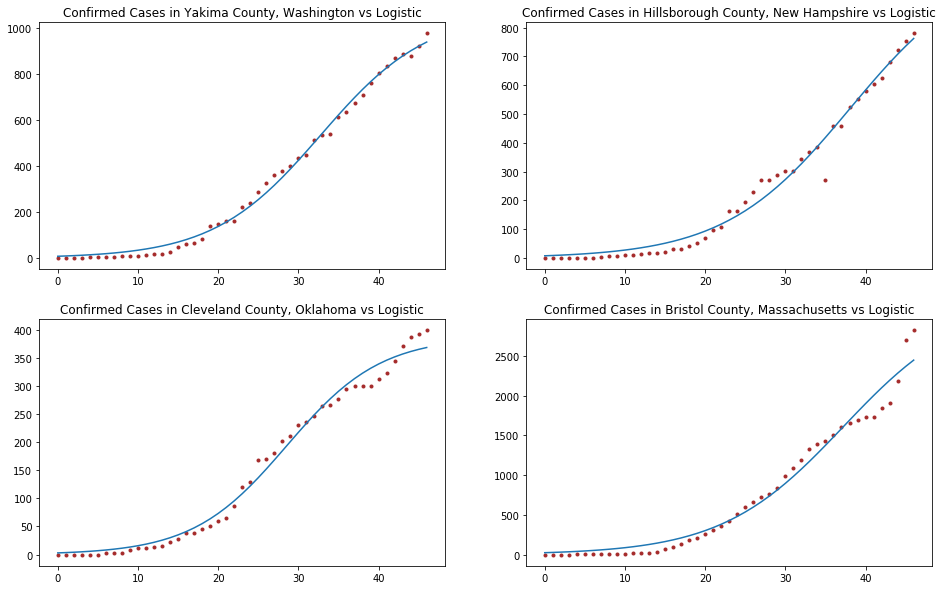

In [15]:
util.graph_examples(filtered, ts_col_name, {"Logistic": log_df})

In [16]:
# And finally a mixture of two copies of the logistic function
log2_df = fit_logistic2(ts_col_name)
log2_df

,State,County,Population,Result_Object,Max1,Rate1,Offset1,Max2,Rate2,Offset2,Switch_Begin,Switch_End,Curve,R^2
FIPS,,,,,,,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 201.63256147578198, 'jac': [-0.0035186...",245.038800,10.000000,34.781092,245.019899,0.102403,41.581561,12.109254,17.016210,[8.32437519e-02 1.12277800e-01 1.51232716e-01 2...,0.998158
1017,Alabama,Chambers,33254,"{'fun': 1134.6529707401673, 'jac': [-0.2126171...",350.605324,1.353433,31.336460,350.554596,0.102075,31.660791,16.000365,20.952034,[1.54787898e-01 2.08389934e-01 2.80276179e-01 3...,0.997787
1055,Alabama,Etowah,102268,"{'fun': 258.9518120756304, 'jac': [-0.02817159...",144.533194,0.285642,29.825873,112.154563,0.575637,40.561896,36.253407,47.000000,[2.82791530e-02 3.75557780e-02 4.98654864e-02 6...,0.996999
1073,Alabama,Jefferson,658573,"{'fun': 4479.029347524156, 'jac': [-0.55333657...",1646.320314,1.406070,30.930859,1618.936007,0.044933,47.000000,10.764860,15.232969,[ 4.00733094 5.18714194 6.70361138 8.646...,0.998715
1081,Alabama,Lee,164542,"{'fun': 1843.754470711409, 'jac': [-0.13810677...",116.634139,10.000000,29.778206,495.465026,0.136429,29.659791,0.000404,44.008885,[ 3.96717082 4.59075502 5.3097681 6.138...,0.997451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55101,Wisconsin,Racine,196311,"{'fun': 639.9439482746395, 'jac': [-0.06323261...",498.832681,1.724443,30.686882,505.294894,0.097648,47.000000,11.651554,16.151809,[9.86322733e-02 1.35017799e-01 1.84591200e-01 2...,0.997575
55105,Wisconsin,Rock,163354,"{'fun': 223.0677848785173, 'jac': [0.0, -0.011...",734.040658,0.729979,47.000000,116.924948,0.185769,27.787600,0.000000,47.000000,[ 0.31184003 0.37931116 0.46121996 0.560...,0.996365
55127,Wisconsin,Walworth,103868,"{'fun': 891.3903642279281, 'jac': [0.000159161...",174.499108,0.137115,40.825376,174.829941,0.157358,40.797528,10.029251,19.998389,[ 0.58424623 0.66501888 0.75668207 0.860...,0.985715


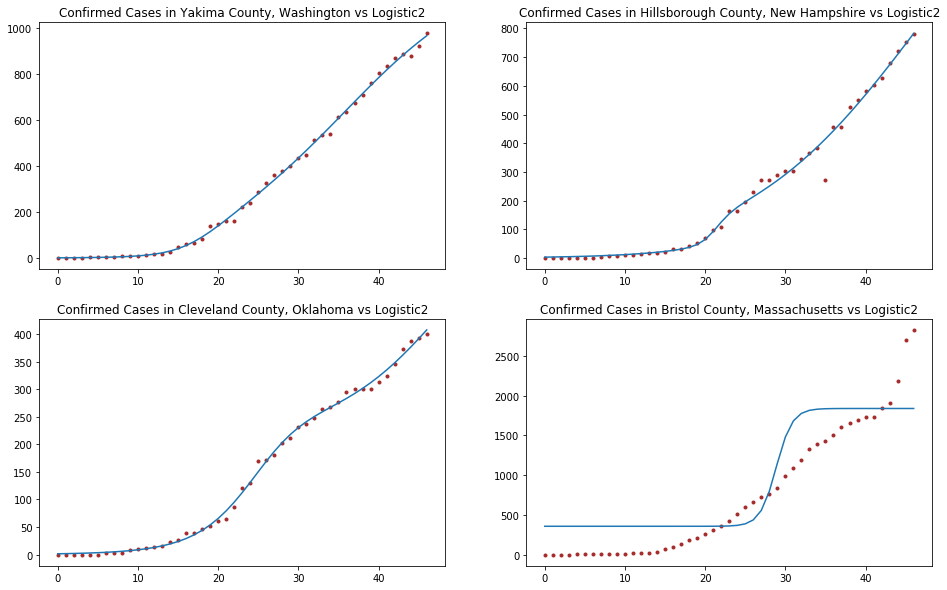

In [17]:
util.graph_examples(filtered, ts_col_name, {"Logistic2": log2_df})

In [18]:
# Stuff all the curves that we have fit into a single dataframe,
# along with the original series' values
curves_df = filtered[metadata_cols + [ts_col_name, outlier_col_name]].copy()
curves_df["Exponential"] = exp_df["Curve"]
curves_df["Logistic"] = log_df["Curve"]
curves_df["Logistic2"] = log2_df["Curve"]
curves_df

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.12112042 1.25691099 1.409...,[ 0.75409466 0.87776585 1.02160168 1.188...,[8.32437519e-02 1.12277800e-01 1.51232716e-01 2...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.14022777 1.30011936 1.482...,[ 0.5193638 0.64156192 0.79243101 0.978...,[1.54787898e-01 2.08389934e-01 2.80276179e-01 3...
1055,Alabama,Etowah,102268,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11727607 1.24830582 1.394...,[ 0.22109095 0.26953866 0.32857448 0.400...,[2.82791530e-02 3.75557780e-02 4.98654864e-02 6...
1073,Alabama,Jefferson,658573,[ 0 0 0 1 1 5 17 21 25 34 50 6...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.16697306e+00 1.36182612e+00 1...,[ 15.16306677 17.60584955 20.43169486 23.697...,[ 4.00733094 5.18714194 6.70361138 8.646...
1081,Alabama,Lee,164542,[ 0 0 0 0 0 0 1 3 8 10 11 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.14577107 1.31279135 1.504...,[ 2.72881123 3.20401358 3.7611422 4.414...,[ 3.96717082 4.59075502 5.3097681 6.138...
...,...,...,...,...,...,...,...,...
55101,Wisconsin,Racine,196311,[ 0 0 0 1 1 1 1 1 1 3 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.13255135 1.28267257 1.452...,[ 1.47777235 1.70319504 1.96277544 2.261...,[9.86322733e-02 1.35017799e-01 1.84591200e-01 2...
55105,Wisconsin,Rock,163354,[ 0 0 0 0 0 0 0 0 0 0 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11402615 1.24105425 1.382...,[ 1.91157133 2.11909047 2.348928 2.603...,[ 0.31184003 0.37931116 0.46121996 0.560...
55127,Wisconsin,Walworth,103868,[ 0 0 0 0 0 0 0 0 1 2 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11332211 1.23948611 1.379...,[ 0.4156606 0.48093501 0.55642947 0.643...,[ 0.58424623 0.66501888 0.75668207 0.860...


In [19]:
# Expand out the tensors to multiple rows for writing to a CSV file, and
# cast the boolean values back to np.bool
curves_vertical = util.explode_time_series(curves_df, filtered_dates)
curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1003  2020-03-10  Alabama  Baldwin      223234          0              False   
      2020-03-11  Alabama  Baldwin      223234          0              False   
      2020-03-12  Alabama  Baldwin      223234          0              False   
      2020-03-13  Alabama  Baldwin      223234          0              False   
      2020-03-14  Alabama  Baldwin      223234          0              False   
...                   ...      ...         ...        ...                ...   
56021 2020-04-21  Wyoming  Laramie       99500        110              False   
      2020-04-22  Wyoming  Laramie       99500        114              False   
      2020-04-23  Wyoming  Laramie       99500        117              False   
      2020-04-24  Wyoming  Laramie       99500        120              False   
      2020-04-25  Wyoming  Laramie       99500        124              False   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1003  2020-03-10     1.000000    0.754095    0.083244  
      2020-03-11     1.121120    0.877766    0.112278  
      2020-03-12     1.256911    1.021602    0.151233  
      2020-03-13     1.409149    1.188848    0.203372  
      2020-03-14     1.579825    1.383260    0.272955  
...                       ...         ...         ...  
56021 2020-04-21    97.571707   98.578561  109.945998  
      2020-04-22   108.814998  103.947668  119.460631  
      2020-04-23   121.353865  109.400848  117.794077  
      2020-04-24   135.337599  114.918237  116.287890  
      2020-04-25   150.932694  120.478993  114.935157  

[30221 rows x 8 columns]

In [20]:
# Write out the results to a CSV file plus a JSON file of type metadata.
curves_vertical.to_csv("data/us_counties_curves.csv", index=True)
col_type_mapping = {
    key: str(value) for key, value in curves_vertical.dtypes.iteritems()
}
with open("data/us_counties_curves_meta.json", "w") as f:
    json.dump(col_type_mapping, f)

In [21]:
# Combine all of the parameters of the curve into another dataframe and
# write that dataframe to a second CSV file.
params = filtered[metadata_cols].copy()
params["Exp_Rate"] = exp_df["Rate"]
params["Exp_Offset"] = exp_df["Offset"]

params["Log_Max"] = log_df["Max"]
params["Log_Rate"] = log_df["Rate"]
params["Log_Offset"] = log_df["Offset"]

params["Log2_Max1"] = log2_df["Max1"]
params["Log2_Rate1"] = log2_df["Rate1"]
params["Log2_Offset1"] = log2_df["Offset1"]
params["Log2_Max2"] = log2_df["Max2"]
params["Log2_Rate2"] = log2_df["Rate2"]
params["Log2_Offset2"] = log2_df["Offset2"]
params["Log2_Switch_Begin"] = log2_df["Switch_Begin"]
params["Log2_Switch_End"] = log2_df["Switch_End"]
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1003,Alabama,Baldwin,223234,0.114329,0.0,177.284243,0.152563,35.760551,245.038800,10.000000,34.781092,245.019899,0.102403,41.581561,12.109254,17.016210
1017,Alabama,Chambers,33254,0.131228,0.0,284.217840,0.211732,29.769072,350.605324,1.353433,31.336460,350.554596,0.102075,31.660791,16.000365,20.952034
1055,Alabama,Etowah,102268,0.110894,0.0,123.709407,0.198530,31.860802,144.533194,0.285642,29.825873,112.154563,0.575637,40.561896,36.253407,47.000000
1073,Alabama,Jefferson,658573,0.154413,0.0,782.991911,0.152555,25.726480,1646.320314,1.406070,30.930859,1618.936007,0.044933,47.000000,10.764860,15.232969
1081,Alabama,Lee,164542,0.136078,0.0,379.217731,0.161801,30.451090,116.634139,10.000000,29.778206,495.465026,0.136429,29.659791,0.000404,44.008885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55101,Wisconsin,Racine,196311,0.124473,0.0,296.500229,0.142735,37.107462,498.832681,1.724443,30.686882,505.294894,0.097648,47.000000,11.651554,16.151809
55105,Wisconsin,Rock,163354,0.107981,0.0,254.178909,0.103884,47.000000,734.040658,0.729979,47.000000,116.924948,0.185769,27.787600,0.000000,47.000000
55127,Wisconsin,Walworth,103868,0.107348,0.0,187.483419,0.146212,41.784218,174.499108,0.137115,40.825376,174.829941,0.157358,40.797528,10.029251,19.998389


In [22]:
params.to_csv("data/us_counties_curves_params.csv", index=True)

In [23]:
!ls -lh data/us_counties_curves*

-rw-r--r--  1 freiss  staff   3.1M Apr 27 19:19 data/us_counties_curves.csv
-rw-r--r--  1 freiss  staff   186B Apr 27 19:19 data/us_counties_curves_meta.json
-rw-r--r--  1 freiss  staff   158K Apr 27 19:19 data/us_counties_curves_params.csv
